# Compressed Sensing (CS) based ECG compressor

## Table of Contents

TO BE WRITTEN

# Goal of Project

TO BE WRITTEN

Roadmap:
- reproducing idea from paper bla bla bla
- in general: study ("emulate", not really) best solution for a CS-based compressor for ECG to be used with remote-ECG-devices, small, limited storage capability, limited computational power:
    - __phase 1__ compute dictionary (only for adaptive dictionaries) $\Psi$ and measurement matrix $\Phi$ before actually using the device to measure the patient ecg
    - __phase 2__ pass $\Psi$, $\Phi$ to the device, take __already compressed measurements__ $y$ (we'll see that this is core idea of CS)
    - __phase 3__ store only $y$, $\Psi$, $\Phi$ and send them back to _more computationally powerful system_ where recovery happens
- paper focuses also on how such hardware is built, we will be more generic
- exploit data from Physionet.org exactly like the paper did
- test different dictionaries, both _fixed dictionaries_ (_DCT_, _DWT_, _KL_) and _adaptive dictionary learning_ (_MOM_, _K-SVD_)
- test how dimension of measurement matrix $\Phi$ is related to processing speed in __phase 2__
- test different _recovery methods_ ("classic" _l1-minimization_, _LASSO_, _Greedy Algorithms_, _Smooth-L0_, _Baisis Pursuit_), always use newly developed __Kronecker technique__ 
- testing robustness to noise with _additive noise_



# Theoretical Review

## Theory: sparsity and compression

### Understanding Sparsity
__Theoretical Sparsity__

A signal $s \in \mathbb{R}^n$ is considered $k$-sparse if it has exactly $k$ non-zero elements, with $k \ll n$. This means that $n-k$ elements of the signal are exactly zero.
$$
s = \begin{pmatrix} s_1 \\ s_2 \\ \vdots \\ s_n \end{pmatrix}
$$
where exactly $k$ elements in $s$ are non-zero, and the remaining $n-k$ elements are zero.


__Practical Sparsity__

In real-world signals, _exact sparsity is rare_. Instead, signals are often _representable_ (see next section) as __approximately sparse__: only $k$ elements _of the sparse representation_ are significant and carry most of the signal's information, the remaining $n-k$ elements have small, negligible values. 

The difference lies in the fact that the $n-k$ coefficients are small but not exactly zero.

### Sparse Representation of Signals

"Most natural signals, such as images and audio, are highly compressible. This compressibility means that, when the signal is written in an appropriate basis, only a few modes are active, thus reducing the number of values that must be stored for an accurate representation. In other words, a compressible signal $x \in \mathbb{R}^n$ may be written as a sparse vector $s \in \mathbb{R}^n$ in a transform basis $\Psi \in \mathbb{C}^{n \times n}$:

$$
x = \Psi s.
$$

If the basis $\Psi$ is generic, such as the Fourier or wavelet basis, then only the few active terms in $s$ are required to reconstruct the original signal $x$, reducing the data required to store or transmit the signal." [2]

### Classic Transformation-Based Compression

A typical transformation-based compression algorithm involves the following steps:

1. __Signal capture__: 
    Fully sense a whole __raw__ signal $x$ and store it. In this project $x$ are the _voltages_ measured by the ECG machine.
2. __Transformation to a sparse domain__:
    The signal $x$ is transformed to a sparse domain, basically we want to find the sparse vector $s \in \mathbb{R}^n$, that contain mostly negligible coefficients.

    We exploit $\Psi \in \mathbb{C}^{n \times n}$ orthogonal basis matrix, also called __dictionary__. Being $\Psi$ an orthonormal basis, it satisfies $\Psi^H \Psi = I$, where $\Psi^H$ is the Hermitian conjugate (conjugate transpose) of $\Psi$, and $I$ is the identity matrix. This implies that $\Psi^{-1} = \Psi^H$, making the transformation and its inverse straightforward.

    Therefore, when $ \Psi $ is an orthonormal basis, applying $ \Psi^H $ to the signal effectively inverts the transformation applied by $ \Psi $, we can use this to obtain sparse representation from original signal:

    $$
    s = \Psi^H x
    $$

    __The use of transforms__:
    On a mathematical note: $\Psi$ is an orthonormal basis composed of functions like Fourier Function, Wavelet, and so on.
    The actual computation of $s$ doesn't actually build a dictionary $\Psi$ to invert and multiplicate to the signal. Instead it directly applies the _transform_ (e.g. FFT, DWT, DCT, ...) to the signal $x$, to immediately obtain _sparse representation_ $s$.

3. __Sparsification__: 
    A fundamental concept is that a threshold is applied to the coefficients, retaining only those that are significant (i.e., above the threshold) and discarding the rest.

    A more detailed view reveals that these steps can be performed using a wide range of techniques, depending on the transform employed, and equivalently, on the choice of dictionary.

    _This will not be explored as it is not the subject of this project, it's a vast and intresting topic, Brunto&Kutz book in reference provide a good reference to explore more..._

4. __Encoding__:
    The retained coefficients and their positions are then encoded for storage or transmission. 

    _Another huge chapter that will not be explored here, again you can refer to the referenced book for more_

__Complexity__

Such methods can be _extremely_ effective, but they require a _thresholding/sparsification_ step, which introduces non-linearity and computational complexity. 

In the following is shown that CS-based methods can provide an alternative solution with different advantages...

<center>
    <img src="./.img/MethodsComparison.png" alt="MethodsComparison.png" width="600">
</center>

### Compressed Sensing (CS)

"Mathematically, compressed sensing exploits the _sparsity of a signal_ in a __generic basis__ to achieve full signal reconstruction from surprisingly few measurements.

If a __signal $x$ is k-sparse in $\Psi$ (it's a requirement),__ then instead of measuring $x$ directly (n measurements) and then compressing, it is possible to collect dramatically fewer randomly chosen or compressed measurements and then solve for the non-zero elements of s in the transformed coordinate system." [2]


#### Measurement

Instead of acquiring all $n$ samples, a reduced set of $m$ measurements is obtained directly by projecting the signal $x$  onto a measurement matrix $\Phi$, storing a _compressed measurement_ $y$:

$$
y = \Phi x
$$


where:
- $x \in \mathbb{R}^n$ _real_ signal coming from sensors
- $y \in \mathbb{R}^m$ _compressed measurement_
- $\Phi \in \mathbb{R}^{m \times n}$ with $m \ll n$ is the _measurement matrix_.

__Key concept__:

In the measurement phase the _sparse representation_ $s$ is __not__ computed, we directly apply the _measurement matrix_ to the _real_ signal $x$. 

$\Phi$ does not simply "select" $m$ out of $n$ coefficients out of $x$. Instead, $\Phi$ typically contains random or structured elements that ensure the measurements $y$ retain sufficient information to __later recover__ the sparse signal $s$. 

Although the _signal $x$ itself is not sparse in the time domain_, __compressed sensing theory exploits the fact that $s$ can be sparsely represented in some transform domain__ (e.g., wavelet or Fourier domain).

_Measurement matrix topic is explored some chapters ahead_


#### Recovery

With knowledge of $s \in \mathbb{R}^n$ _sparse representation_ of $x$ through $\Psi$ _dictionary_, it is possible to recovery $x$ itself as previously shown with:
$$
x = \Psi s
$$

Thus the goal of compressed sensing is to find the __sparsest__ vector $s$ that is consistent with:

$$
y = \Phi x = \Phi \Psi s
$$

where (again):
- $x \in \mathbb{R}^n$ _real_ signal coming from sensors
- $y \in \mathbb{R}^m$ _compressed measurement_
- $\Psi \in \mathbb{R}^{n \times n}$ is the _dictionary_ (same as explained in previous section)
- $\Phi \in \mathbb{R}^{m \times n}$ with $m \ll n$ is the _measurement matrix_.
- $s \in \mathbb{R}^n$ is the _sparse representation_ of $x$ in $\Psi$

__Non convex problem__

"Such system of equations is __under-determined__ since there are infinitely many consistent solution $s$. The __sparsest solution__ is the one that satisfies:

$$
\hat{s} = \arg_{s} \min \|s\|_0 \text{ subject to } y = \Phi \Psi \alpha
$$

where $\min \|s\|_0$ denotes the $\ell_0$-pseudo-norm, given by the _non-zero entries_, also referred as the _cardinality_ of $s$.

The optimization is non-convex, and in general, the solution can only be found with a brute-force search that is combinatorial in $n$ and $K$. In particular, all possible $K$-sparse vectors in $\mathbb{R}^n$ must be checked; if the exact level of sparsity $K$ is unknown, the search is even broader. Because this search is combinatorial, solving such minimization is intractable for even moderately large $n$ and $K$, and the prospect of solving larger problems does not improve with Moore’s law of exponentially increasing computational power."[2]

__Convex equivalent problem__

Fortunately, under certain conditions on the measurement matrix $\Phi$, it is possible to relax the optimization to a convex $\ell_1$-minimization.

$$
\hat{s} = \arg_{s} \min \|s\|_1 \text{ subject to } y = \Phi \Psi \alpha
$$

__In the presence of noise__, the recovery problem is modified to:

$$
\hat{s} = \arg_{s} \min \|s\|_1 \text{ subject to } \|y - \Phi \Psi s\|_2 \leq \epsilon
$$

where $\epsilon$ is a bound on the noise level.

There are very specific conditions that must be met for the $\ell_1$-minimization to converge with high probability to the sparsest solution of $\ell_0$-minimization. They can be summarized as follows:
- __Incoherence__: 
    A critical concept in compressed sensing is the _incoherence_ between the measurement matrix $\Phi$ and the dictionary $\Psi$. Incoherence refers to the property that ensures that the rows of $\Phi$ are not too similar to the columns of $\Psi$. This incoherence is vital because it allows the sparse information in the signal $x$ (which is represented in the domain of $\Psi$) to be evenly spread across the measurements $y$. This spreading ensures that no single measurement in $y$ captures too much or too little information about the signal $x$, which is essential for accurate recovery of the sparse signal $s$ from the measurements $y$.

- __Recoverability Condition:__ 
    A $K$-sparse signal $s \in \mathbb{R}^n$ can be properly recovered after Compressive Sensing (CS) if the number of measurements $m$ satisfies:

    $$
    m \geq C K \log\left(\frac{n}{K}\right)
    $$

    where $C$ is a constant that depends on how __incoherent__ $\Phi$ and $\Psi$ are. This condition ensures that enough measurements are taken to accurately recover the sparse signal, accounting for both sparsity and the ambient dimension $n$.

    The recoverability condition is a practical guideline that tells you how many measurements $m$ you need to take to ensure that a $k$-sparse signal $s \in \mathbb{R}^n$ can be recovered accurately. The $\log\left(\frac{n}{k}\right)$ term accounts for the dimensionality reduction that occurs when mapping an $n$-dimensional signal into an $m$-dimensional measurement space.

"Roughly speaking, these two conditions guarantee that the matrix $\Phi |Psi$ acts as a unitary transformation on K-sparse vectors $s$, preserving relative distances between vectors and enabling almost certain signal reconstruction with $\ell_1$ convex minimization. This is formulated precisely in terms of the restricted isometry property (RIP) that follows."[2]

- __Restricted Isometry Property (RIP):__
    "The RIP is a property of the matrix $A = \Phi \Psi$ that provides a condition under which the matrix will behave well with respect to sparse signals. Specifically, for a matrix $A$ to satisfy the RIP of order $k$ with a constant $\delta_k$, it must hold that:

    $$
    (1 - \delta_k) \|x\|_2^2 \leq \|A x\|_2^2 \leq (1 + \delta_k) \|x\|_2^2
    $$

    for all $k$-sparse vectors $x$. Here, $\delta_k$ is the smallest constant such that this inequality holds, and it should be close to zero. This ensures that the matrix $A$ approximately preserves the Euclidean length (and hence the geometry) of all $k$-sparse signals, meaning the measurements are nearly isometric.


__LASSO Compressed Sensing__

Alternatively, the signal can be recovered using the LASSO formulation, which balances the $\ell_1$ norm of the signal with the fidelity to the measurements:

$$
\hat{s} = \arg \min \left(\frac{1}{2} \|y - \Phi \Psi s\|_2^2 + \lambda \|s\|_1 \right)
$$

Here, $\lambda$ is a regularization parameter that controls the trade-off between the sparsity of the solution and the accuracy of the reconstruction. A larger $\lambda$ emphasizes sparsity, while a smaller $\lambda$ emphasizes data fidelity.

Note that $LASSO$ formulation already accounts for noise using the $\ell_2$ minimization on $\|y - \Phi \Psi s\|_2^2$, instead of enforcing the condition $y = \Phi \Psi s$.

## Theory: main aspects of study and evaluation metrics

### Aspects relevant to the study

__Work on signal block__

ECG provide continuous data sampling, a record length can vary based on why it is being taken from few minutes, to hours, to days. This work addresses small devices, that will take a number of samples that can vary between 16 and 1024 as __signal block to compress__.

__Compression ratio (CR)__

"Important factor for evaluating different methods. CR as follow 
$$
CR(\%) = 100 \frac{n - m}{n}
$$
where $m$ and $n$ are the number of compressed and original samples, respectively. "[1]

__Compression algorithm’s complexity__

Very relevant "when we talk about limited and weak ECG-recorders. The power consumption usually has a linear relation with the complex-ity of systems. Supplying the power for 24-h ambulatory or remote ECG recorders is very important, that encourage 
us to focus on systems that have low power consumption."[1]

The focus here is especially on _sampling phase_: one of the goal of the project will be to demonstrate, same as they did in the paper, that a smaller _measurement matrix_ will result in a _more efficient sampling phase_.

__Processing speed__

"In emergency situations it will be important. Considering the ambulatory ECG recorders, whatever the data sooner to be presented to a physician, the next orders from a physician can be given sooner as well."

Here it must be also taken into account the _reconstruction complexity_, in order to provide _usable_ ECG data, it's necessary to be fast both in acquirin and processing the data.

_In this work are reproposed the same fundamental metrics and evaluation aspects proposed in the [1] Izadi, V., Shahri, P.K., & Ahani, H. (2020) paper.

### Metrics to Assess the Accuracy of Reconstructed Signal

The accuracy of the reconstructed signal in ECG compression algorithms is typically evaluated using two common metrics: the Percentage Root Mean Square Difference (PRD) and Signal-to-Noise Ratio (SNR). These metrics are defined as follows:
__Percentage Root Mean Square Difference (PRD)__
The PRD is a measure of the difference between the original ECG signal and the reconstructed ECG signal. It is calculated using the following equation:

$$
\text{PRD} = 100 \times \sqrt{\frac{\sum_{i=0}^{N-1} (x(n) - \hat{x}(n))^2}{\sum_{i=0}^{N-1} x(n)^2}}
$$

where:
- $x(n)$ is the original ECG signal.
- $\hat{x}(n)$ is the reconstructed ECG signal.
- $N$ is the length of the signal.

__Signal-to-Noise Ratio (SNR)__
The SNR is another measure used to assess the quality of the reconstructed signal. It is calculated from the PRD using the following equation:

$$
\text{SNR} = -20 \log_{10} \left(\frac{\text{PRD}}{100}\right)
$$

### Quality Assessment Based on PRD and SNR

Table 1 from the referenced paper classifies the quality of the reconstructed signal based on the PRD and corresponding SNR values:

| Quality        | PRD Range      | SNR Range       |
|----------------|----------------|-----------------|
| Very Good      | 0% < PRD < 2%  | SNR > 33 dB     |
| Good           | 2% < PRD < 9%  | 20 dB < SNR < 33 dB |
| Undetermined   | PRD ≥ 9%       | SNR ≤ 20 dB     |

This table indicates that when the PRD is less than 2%, the quality of the reconstructed signal can be categorized as "Very Good." For PRD values between 2% and 9%, the quality is considered "Good," and for PRD values above 9%, the quality of the reconstructed signal cannot be precisely determined. __In this study the same metric will be adopted__.

_Table based on [1] Izadi, V., Shahri, P.K., & Ahani, H. (2020). A compressed-sensing-based compressor for ECG. *Biomedical Engineering Letters*, 10, 299–307. https://doi.org/10.1007/s13534-020-00148-7_

_More information on how such measure was established in APPENDIX_

## Theory: measurement matrix

TO BE WRITTEN

Roadmap:
- Relation between $\Phi$ dimension and speed of "sensing phase" (phase 2)
- Relation between randomicity and RIP property

As previously mentioned ant _ECG device_ provide continuous data sampling for consectuive hours, for instance MIT-BIH Arrhythmia Database provides _records_ for each patient for about $30$ consecutive hours, sampled at $360$ $samples/second$. This means that each _record_ has about $650000$ samples.

Exploiting _Compressed Sensing_ allows to store only a fraction of such data by immediately computing the _compress measurement_, this work won't delve into the __hardware__ specifics, the [1] Izadi, V., Shahri, P.K., & Ahani, H. (2020) paper provides a possible hardware implementation.

What is important to understand in the present study is that on an ECG signal CS-based approach works on _groups of consecutive samples_ within a _record_, each _"group"_ is a __signal blocks__.




### Compressing blocks of samples within signal

For the whole signal we understood that CS performs:
$$
y = \Phi x
$$

where:
- $x \in \mathbb{R}^n$ _real_ signal coming from sensors
- $y \in \mathbb{R}^m$ _compressed measurement_
- $\Phi \in \mathbb{R}^{m \times n}$ with $m \ll n$ is the _measurement matrix_.

In the practical case "the signal $x$" becomes the single __signal block__ $y_{block} \in \mathbb{R}^d$, where $d$ is the _block size_.

$$
y_{block} = \Phi_{p,d} \cdot x_{block}
$$

Where $p \ll d$, $\Phi_{p,d}$ will reduce $d$ _original samples_ to $p$ samples that compose _compressed measurement_ __for that single block__. 

__Compressed measurement $y$ of the whole signal is then obtained by simply concatenating previous results__



### How the measurement matrix is generated

In the present work, elements of $\Phi_{p,d}$ are drawn from a Bernoulli distribution, which is a discrete probability distribution.

For each element $\phi_{ij}$ of the matrix $\Phi$, a random value is generated that is either $+1$ or $-1$ with equal probability.

__How to Check that Restricted Isometry Property holds__

As previously explained in the theoretical review the Restricted Isometry Property (RIP) is crucial in ensuring that compressed sensing can accurately recover sparse signals from a reduced set of measurements. 

However checking whether a specific matrix $A$ satisfies the RIP is computationally infeasible for large matrices because it would involve verifying this condition across all possible sparse vectors. 

Despite this difficulty, generating the measurement matrix $\Phi$ randomly ensures that $A = \Phi \Psi$ is very likely to satisfy the RIP.__*__ This inherent randomness provides a strong theoretical basis for the effectiveness of compressed sensing without the need for direct verification of the RIP.[1]

__How many measurement matrices?__

The project aims to emulate what would be possible to do on a very small device with __limited computation capabilities and storage capacity__, to find the best methods in such system. 

Even though it's technically possible to use a different random _measurement matrix_ for each __signal block__, the idea is to use the same $\Phi$ for the whole signal, as it would be advisable to do in a portable ECG device.

Otherwise it'd be necessary to store a measurement matrix for each block, and reassociate it to such block during _recovery phase_. It would not be the best way to proceed.

__Choice of block dimension__

One of the goals of this study is to demonstrate that a smaller value of $d$, hence a smaller _measurement matrix_ $\Phi$ will result in a more efficient (time complexity-wise) compression process.

In the next code block we choose a very small __block size__ $d$, in the last part of the project we will provide an actual study of the relation between the processing time and the __block size__, experiment with different matrices: $\Phi_{4,16}, \Phi_{8,32}, \Phi_{16,64}, \Phi_{32,128}, \Phi_{64,256}, \Phi_{128,512}, \Phi_{256,1024}$

__By construction the method will produce a 75% Compression Ratio__ due to the dimension choosen for $\Phi_{p,d}$ because $p = d/4$ in all cases.

## Theory: reconstruction of the signal

### Reconstruction methods

__"classic" _l1-minimization_ problem__
TO BE WRITTEN

__LASSO__
TO BE WRITTEN

__Greedy Algorithms__
TO BE WRITTEN

__Smooth-L0__
TO BE WRITTEN

__Basis Pursuit__
TO BE WRITTEN

### Dictionaries

#### _fixed dictionaries_ vs _adaptive dictionary learning_
TO BE WRITTEN


#### Fixed dictionaries

__DCT__
TO BE WRITTEN

__DWT__
TO BE WRITTEN

__KL__
TO BE WRITTEN


#### Adaptive Dictionary Learning
TO BE WRITTEN

__MOM__
TO BE WRITTEN

__K-SVD__
TO BE WRITTEN

### Kronecker Techinque

TO BE WRITTEN

# Code implementation (python)

---

__Sampling phase__
- $y = \Phi x$, simulate what would happen on device (_compute block by block, later concatenate results_)

---

__Recovery phase__
- Reconstruct $\hat{s}$, approximation of $s$ _sparse representation_ of $x$
- Use dictionary $\Psi$ to retrieve $\hat{x}$ approximation of $x$ 

--- 

__Evaluate result__
1. Sampling faster for smaller $\Phi$?
2. Which dictionary are the best? (How fast, how accurate)
3. Which recovery method is best? (How fast, how accurate)
4. Robustness to noise?

---

## Code: sampling phase

### Measurement matrix $\Phi$

In [1]:
import numpy as np

def generate_measurement_matrix(rows, cols):
    """
    Generates a random measurement matrix with the specified number of rows and columns.

    Parameters:
    - rows (int): The number of rows in the measurement matrix.
    - cols (int): The number of columns in the measurement matrix.

    Returns:
    - numpy.ndarray: The generated measurement matrix with shape (rows, cols).

    Description:
    This function generates a random measurement matrix with the specified number of rows and columns. 
    The measurement matrix is created by randomly choosing either -1 or 1 for each element in the matrix.
    The resulting matrix is returned as a numpy array.
    """

    return np.random.choice([-1, 1], size=(rows, cols))

### Signal Sampling $y = \Phi x$

In [2]:
import numpy as np

def compute_compressed_measurement(signal, signal_block_dimension):
    """
    Computes the compressed measurement of a signal using compressed sensing.

    Parameters:
    - signal (numpy.ndarray): The input signal.
    - signal_block_dimension (int): The dimension of each signal block.

    Returns:
    - numpy.ndarray: The compressed measurement of the signal.
    - numpy.ndarray: The measurement matrix used for compression.

    Description:
    This function computes the compressed measurement of a signal using compressed sensing.
    It generates a measurement matrix with the specified number of columns based on the signal block dimension.
    Then, it computes the compressed measurement block by block and concatenates the results to obtain the compressed measurement of the whole signal.
    The resulting compressed measurement and measurement matrix are returned as numpy arrays.
    """

    # Number of blocks
    num_blocks = len(signal) // signal_block_dimension

    # To a achieve 75% compression rate: the number of rows in the measurement matrix is set to 1/4 of the signal block dimension
    NUM_OF_ROWS = signal_block_dimension // 4

    # Generate measurement matrix
    measurement_matrix = generate_measurement_matrix( NUM_OF_ROWS, signal_block_dimension)

    # Initialize the compressed measurement
    compressed_measurement = np.empty(0)

    # Compute the compressed measurement block by block
    for i in range(num_blocks):
        
        # Get the current block of the signal
        block = signal[i * signal_block_dimension : (i + 1) * signal_block_dimension]

        # Compute the compressed measurement block
        compressed_measurement_block = np.dot(measurement_matrix, block)

        # Concatenate the compressed measurement block to the compressed measurement
        compressed_measurement = np.concatenate((compressed_measurement, compressed_measurement_block))

    return compressed_measurement, measurement_matrix


## Code: recovery phase

The only two things needed out of the _sampling phase_ are $y$ and $\Phi$

Next step is to solve:
$$
\hat{s} = \arg_{s} \min \|s\|_1 \text{ subject to } y = \Phi \Psi \alpha
$$

### Matrix $\Theta = \Phi \Psi$ for fixed dictionaries

It's necessary to compute $\Theta = \Phi \Psi$
- It's not efficient to compute the whole base $\Psi$, it's preferable a _matrix-free_ approach
- We should allow choosing various __fixed dictionaries__
- We need to store what transform we used in order to successfully reconstruct in later steps

In [14]:
import numpy as np
from scipy.fftpack import idct
from pywt import wavedec, waverec

def compute_theta(phi, transform_type='dwt', wavelet='db4'):
    """
    Computes the matrix Theta = Phi * Psi using a matrix-free approach with the DCT or DWT as the basis for Psi.
    Also returns the transform type and wavelet type (if applicable).

    Parameters:
    - phi (numpy.ndarray): The measurement matrix Phi of shape (m, n).
    - transform_type (str): The type of transform to use. Can be 'dwt' (default) or 'dct'.
    - wavelet (str): The type of wavelet to use for DWT. Default is 'db4'.

    Returns:
    - tuple: (Theta, transform_type, wavelet_type)
      - Theta (numpy.ndarray): The matrix Theta of shape (m, n), where Theta = Phi * Psi.
      - transform_type (str): A string indicating the transform used ('dct' or 'dwt').
      - wavelet_type (str or None): The wavelet name if DWT is used; None if DCT is used.
    """

    # Get the number of columns of Phi, equal to signal block dimension
    n = phi.shape[1]

    # Initialize Theta as a zero matrix of shape (m, n)
    m = phi.shape[0]
    theta = np.zeros((m, n))

    # Set the wavelet_type to None initially
    wavelet_type = None

    # Iteratively compute each column of Theta
    for ii in range(n):
        # Create the unit vector ek
        ek = np.zeros(n)
        ek[ii] = 1

        # Compute the corresponding column of Psi using the chosen transform
        if transform_type == 'dct':
            psi_column = idct(ek, norm='ortho')
        elif transform_type == 'dwt':
            # Decompose the unit vector in the wavelet domain
            coeffs = wavedec(ek, wavelet, level=1)
            # Reconstruct the unit vector (basis vector) in the time domain
            psi_column = waverec(coeffs, wavelet)[:n]
            wavelet_type = wavelet  # Set the wavelet_type to the specified wavelet

        # Compute the corresponding column of Theta
        theta[:, ii] = np.dot(phi, psi_column)

    return theta, transform_type, wavelet_type


### Reconstruction Methods

## Code: reconstructed signal evaluation

In [4]:
import numpy as np

def calculate_prd(original_signal, reconstructed_signal):
    """
    Calculate the Percentage Root Mean Square Difference (PRD).
    
    Parameters:
    original_signal (np.array): The original ECG signal.
    reconstructed_signal (np.array): The reconstructed ECG signal.
    
    Returns:
    float: The PRD value as a percentage.
    """
    numerator = np.sum((original_signal - reconstructed_signal) ** 2)
    denominator = np.sum(original_signal ** 2)
    prd = 100 * np.sqrt(numerator / denominator)
    return prd

def calculate_snr(prd):
    """
    Calculate the Signal-to-Noise Ratio (SNR) based on PRD.
    
    Parameters:
    prd (float): The PRD value as a percentage.
    
    Returns:
    float: The SNR value in dB.
    """
    snr = -20 * np.log10(prd / 100)
    return snr


## Code: test for best dictionary

- Test all dictionaries to show with big number of data which are the one to perform better (we expect DWT to be the best of fixed, and that adaptive are better than fixed in general)
- __#Records:__ Test on __MULTIPLE patients__ records is a MUST, especially to show that adaptive are better 
- __#Dictionaries:__ Test all dictionaries, that's what we are doing ...
- __#ReconstructionMethods:__ Test with __only one reconstruction method__

## Code: test for best reconstruction method

- Test to find which recontruction method is the best
- __#Records:__ Test on a __single patient__ record should be fine 
- __#Dictionaries:__ Test with __a single dictionary type__
- __#ReconstructionMethods:__ Test with __all reconstruction methods__

## Code: test for correct block dimension

- Test to show that __sampling phase process speed is inversly proportional to block dimension__
- __#Records:__ Test on a __single patient__ record should be fine 
- __#Dictionaries:__ Test with __a single dictionary type__ (USE BEST!)
- __#ReconstructionMethods:__ Test with __only one reconstruction method__ (USE BEST!)

## Code: test for noise robustness

- Test if robust to noise by adding noise to the signal
- __#Records:__ Test on a __single patient__ record should be fine 
- __#Dictionaries:__ Test with __a single dictionary type__ (USE BEST!)
- __#ReconstructionMethods:__ Test with __only one reconstruction method__ (USE BEST!)

# Data: MIT–BIH Arrhythmia Database

### MIT-BIH Arrhythmia Database

__Source:__ [physionet.org](https://www.physionet.org/content/mitdb/1.0.0/)

__Authors:__ George Moody, Roger Mark

__Version:__ 1.0.0 (Feb. 24, 2005)

__Citation Information__

__Original publication:__
Moody GB, Mark RG. *The impact of the MIT-BIH Arrhythmia Database*. IEEE Eng in Med and Biol 20(3):45-50 (May-June 2001). (PMID: 11446209)

__Citation for PhysioNet:__
Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). *PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals*. Circulation [Online]. 101 (23), pp. e215–e220.

__Background__

Since 1975, laboratories at Boston’s Beth Israel Hospital (now the Beth Israel Deaconess Medical Center) and at MIT have supported research into arrhythmia analysis and related subjects. One of the first major products of that effort was the MIT-BIH Arrhythmia Database, completed and distributed in 1980. The database was the first generally available set of standard test material for evaluating arrhythmia detectors and has been used for that purpose as well as for basic research into cardiac dynamics at more than 500 sites worldwide. Originally, the database was distributed on 9-track half-inch digital tape at 800 and 1600 bpi, and on quarter-inch IRIG-format FM analog tape. In August 1989, a CD-ROM version of the database was produced.

__Data Description__

The MIT-BIH Arrhythmia Database contains:

- 48 half-hour excerpts of __two-channel ambulatory ECG recordings.__
- Data obtained from 47 subjects (1975-1979).
- 23 recordings chosen at random from a set of 4000 24-hour ambulatory ECG recordings from Boston’s Beth Israel Hospital (inpatients 60%, outpatients 40%).
- 25 recordings selected to include less common but clinically significant arrhythmias.
- __Digitized at 360 samples per second per channel with 11-bit resolution over a 10 mV range.__
- Annotations by two or more cardiologists; disagreements resolved to obtain reference annotations (approx. 110,000 annotations).


### Download the database

In [5]:
# Downloading the database (command worked on August 2024, otherwise look for the database on physionet.org)

# This will ignore:
# mitdbdir: html where data is presented and explained (go on website if intrested or download without "--exclude" option)
# *.xws: files that are used to visualize data on a Physionet.org tool called "LightWave" (go on website if intrested or download without "--reject" option)

#!wget -r -N -c -np --reject "*.xws" --exclude-directories=mitdbdir https://physionet.org/files/mitdb/1.0.0/



### Step 1: Retrieving the Data Path

To read the MITDB (MIT-BIH Arrhythmia Database) data using the `wfdb` library, we first need to retrieve the data path. In this Jupyter Notebook, the data path is stored in the `data_folder` variable.
We can use this path to locate the specific record we want to read. In this case, the record number is stored in the `record_number` variable.

To construct the full path to the record, we can use the `os.path.join()` function as follows:



In [6]:
import os

# Define the project root directory (assuming the notebook is in the root directory)
project_root = os.getcwd()  # Gets the current working directory, which is the root in this case

# Define the relative path to the data folder
data_folder = os.path.join(project_root, 'physionet.org', 'files', 'mitdb', '1.0.0')

# Specify the record number
record_number = '100'  # Change this to the desired record number

# Construct the full path to the record
record_path = os.path.join(data_folder, record_number)


# print record_path
print(record_path)


/home/franco/Dropbox/AA_Fra_Rosnati/B_Education/AA_University/AA_PoliMi/AA_Ing/01_Magistrale/HPC_engineering/1_sem_HPC/NAML/NAML_project/NAML_ECG_compressor/physionet.org/files/mitdb/1.0.0/100


### Step 2: Load the signal and annotations
In the code above, we first import the `wfdb` module. Then, we use the `rdrecord()` function to load the signal from the specified `record_path`. We also use the `rdann()` function to load the annotations for the same record. 

After executing this code, the signal will be stored in the `record` variable, and the annotations will be stored in the `annotation` variable.

We will then visualize the whole signal, it's unreadable on a 30 hours time frame, it's only to visually check if downloading went well.

In [7]:
import wfdb

# Load the signal and annotations
record = wfdb.rdrecord(record_path)
annotation = wfdb.rdann(record_name=record_path, extension='atr', shift_samps=True)


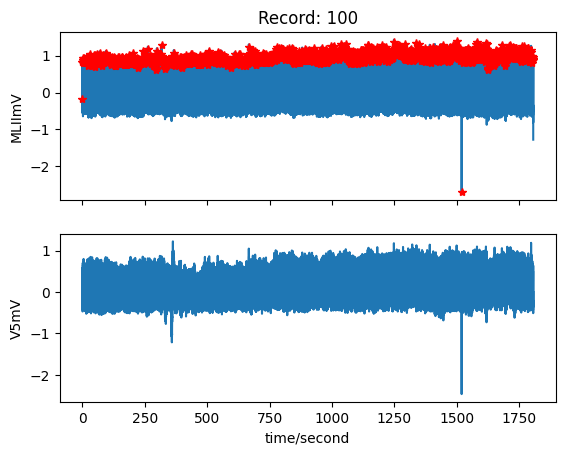

In [8]:
# Plot the signal with annotations, just to check if download went correctly
wfdb.plot_wfdb(record=record, annotation=annotation)

### Step 3: moving data to Pandas dataframe
Simply use the proper function from `wfdb` library

__Annotation will not be ported to pandas dataframe__

In [9]:
import pandas as pd
df = record.to_dataframe()

print(df.head(15))
print("\n")
print(df.dtypes)

                            MLII     V5
0 days 00:00:00           -0.145 -0.065
0 days 00:00:00.002777777 -0.145 -0.065
0 days 00:00:00.005555554 -0.145 -0.065
0 days 00:00:00.008333331 -0.145 -0.065
0 days 00:00:00.011111108 -0.145 -0.065
0 days 00:00:00.013888885 -0.145 -0.065
0 days 00:00:00.016666662 -0.145 -0.065
0 days 00:00:00.019444439 -0.145 -0.065
0 days 00:00:00.022222216 -0.120 -0.080
0 days 00:00:00.024999993 -0.135 -0.080
0 days 00:00:00.027777770 -0.145 -0.085
0 days 00:00:00.030555547 -0.150 -0.085
0 days 00:00:00.033333324 -0.160 -0.075
0 days 00:00:00.036111101 -0.155 -0.070
0 days 00:00:00.038888878 -0.160 -0.070


MLII    float64
V5      float64
dtype: object


## PART II: visualize the ECG data

The ECG wave consists of three main components: the P wave, the QRS complex, and the T wave.

- The P wave represents atrial depolarization, which is the contraction of the atria. It is typically a small and smooth upward deflection.
- The QRS complex represents ventricular depolarization, which is the contraction of the ventricles. It consists of three distinct waves: Q, R, and S. The Q wave is the first downward deflection, the R wave is the first upward deflection after the Q wave, and the S wave is the downward deflection after the R wave.
- The T wave represents ventricular repolarization, which is the recovery of the ventricles. It is typically a smooth upward deflection.

The typical duration of the P wave is around 80-100 milliseconds, the QRS complex lasts around 80-120 milliseconds, and the T wave lasts around 160-240 milliseconds.

The distance between waves can vary depending on the heart rate. In a normal sinus rhythm, the distance between consecutive P waves (P-P interval) is usually consistent and represents the atrial rate. The distance between consecutive R waves (R-R interval) represents the ventricular rate. The normal range for the R-R interval is around 600-1000 milliseconds.

When plotting hours-long ECG data, the waves become densely packed, making it difficult to interpret the waveform patterns. To overcome this, we can plot a specific interval of the ECG data by selecting a starting time and duration. This allows us to focus on a specific part of the ECG waveform and make it more interpretable.

In [10]:
# %matplotlib widget
import matplotlib.pyplot as plt


def plot_ecg_interval(df, start=0, duration=1, fs=360):
    """
    Plot an interval of ECG data.

    Parameters:
    - df: DataFrame containing the ECG data with time as index.
    - start: Starting time in seconds for the plot.
    - duration: Duration in seconds of the interval to plot.
    - fs: Sampling frequency (samples per second).
    """
    start_sample = int(start * fs)
    end_sample = int((start + duration) * fs)
    
    interval_df = df.iloc[start_sample:end_sample]
    
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # Plot MLII in the first subplot
    axes[0].plot(interval_df.index, interval_df['MLII'], label='MLII')
    axes[0].set_ylabel('Amplitude (mV)')
    axes[0].set_title(f'ECG MLII Data from {start} to {start + duration} seconds')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot V5 in the second subplot
    axes[1].plot(interval_df.index, interval_df['V5'], label='V5', color='orange')
    axes[1].set_xlabel('Time (seconds)')
    axes[1].set_ylabel('Amplitude (mV)')
    axes[1].set_title(f'ECG V5 Data from {start} to {start + duration} seconds')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()


This can be useful when deciding portion of data to work on

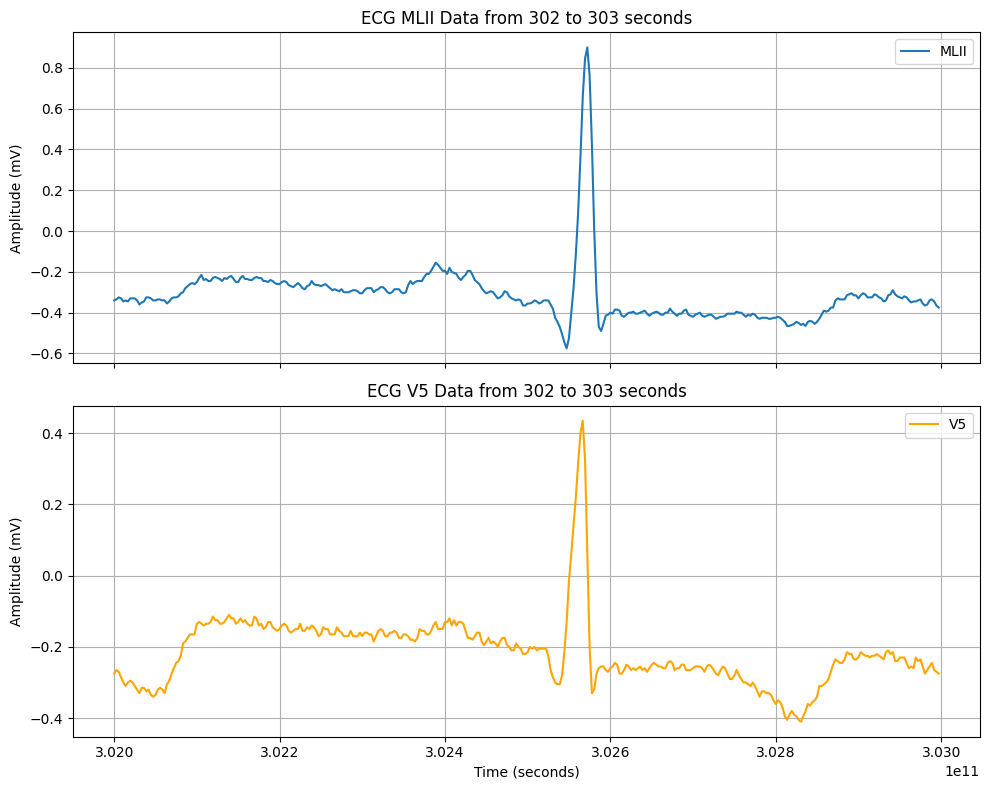

In [11]:
# Plot "duration" number of seconds of ecg data starting at "start" seconds
plot_ecg_interval(df, start=302, duration=1) # Change the start and duration values as needed

# Run the tests

# Conclusions

TO BE WRITTEN

# References

Direct quotation are enclosed in `"..."` and are followed by a reference number inside `[]`

[1] Izadi, V., Shahri, P.K., & Ahani, H. (2020). A compressed-sensing-based compressor for ECG. *Biomedical Engineering Letters*, 10, 299–307. https://doi.org/10.1007/s13534-020-00148-7

[2] __Chapter 3.1 "Sparsity and Compressed Sensing" of the Book__:
   Brunton, S. L., & Kutz, J. N. (2022). *Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control* (2nd ed.). Cambridge University Press.

__Data__:

Moody GB, Mark RG. *The impact of the MIT-BIH Arrhythmia Database*. IEEE Eng in Med and Biol 20(3):45-50 (May-June 2001). (PMID: 11446209)

Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). *PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals*. Circulation [Online]. 101 (23), pp. e215–e220.



# Appendix

TO BE WRITTEN?

For instance explanation of what ecg is

### Quality Assessment Based on PRD and SNR

Table 1 from the referenced paper classifies the quality of the reconstructed signal based on the PRD and corresponding SNR values:

| Quality        | PRD Range      | SNR Range       |
|----------------|----------------|-----------------|
| Very Good      | 0% < PRD < 2%  | SNR > 33 dB     |
| Good           | 2% < PRD < 9%  | 20 dB < SNR < 33 dB |
| Undetermined   | PRD ≥ 9%       | SNR ≤ 20 dB     |

This table indicates that when the PRD is less than 2%, the quality of the reconstructed signal can be categorized as "Very Good." For PRD values between 2% and 9%, the quality is considered "Good," and for PRD values above 9%, the quality of the reconstructed signal cannot be precisely determined. 

__Metric Based on Physician Qualitative Assessments__

The classification of the PRD and SNR values into "Very Good," "Good," and "Undetermined" categories was established based on a study by Zigel et al., which is referenced in the paper. In this study, a link was established between the diagnostic distortion of ECG signals and the PRD metric. The researchers conducted qualitative assessments with physicians, who evaluated the diagnostic quality of reconstructed ECG signals at different PRD levels.

The physicians' qualitative assessments provided a subjective but clinically relevant measure of how much distortion could be tolerated in the reconstructed signals before it began to interfere with accurate diagnosis. These evaluations were then correlated with specific PRD values, allowing the researchers to define thresholds where the signal quality was deemed acceptable or unacceptable for clinical use. For instance, a PRD of less than 2% was consistently associated with minimal diagnostic distortion, leading to its classification as "Very Good." As PRD increased, the likelihood of clinically significant distortion also increased, which was reflected in the "Good" and "Undetermined" categories.

This physician-based qualitative assessment was crucial in grounding the PRD and SNR metrics in practical clinical utility, ensuring that the numerical 
thresholds corresponded to meaningful diagnostic criteria.

_Based on [1] Izadi, V., Shahri, P.K., & Ahani, H. (2020). A compressed-sensing-based compressor for ECG. *Biomedical Engineering Letters*, 10, 299–307. https://doi.org/10.1007/s13534-020-00148-7_
